In [2]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Connexion à la base SQLite

In [3]:
conn = sqlite3.connect("../Source/olist.db")

## Nous allons charger les tables pertinentes (customers, orders, order_items, order_reviews, order_pymts..)
## Fusionner les données pour avoir un client = une ligne

### Execution d'une requete dans une string et l'utiliser au travers d'une fonction pandas query sql

In [4]:
query = """
SELECT
    c.customer_unique_id,
    COUNT(DISTINCT o.order_id) AS nb_orders,
    MIN(o.order_purchase_timestamp) AS first_order_date,
    MAX(o.order_purchase_timestamp) AS last_order_date,
    ROUND(SUM(oi.price + oi.freight_value), 2) AS total_spent,
    AVG(r.review_score) AS avg_review_score,
    COUNT(DISTINCT op.payment_type) AS nb_payment_types
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
LEFT JOIN order_items oi ON o.order_id = oi.order_id
LEFT JOIN order_reviews r ON o.order_id = r.order_id
LEFT JOIN order_pymts op ON o.order_id = op.order_id
GROUP BY c.customer_unique_id;
"""

In [5]:
df_clients = pd.read_sql_query(query, conn)

In [6]:
df_clients

,customer_unique_id,nb_orders,first_order_date,last_order_date,total_spent,avg_review_score,nb_payment_types
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,2018-05-10 10:56:27,141.90,5.0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,2018-05-07 11:11:27,27.19,4.0,1
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,2017-03-10 21:05:03,86.22,3.0,1
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,2017-10-12 20:29:41,43.62,4.0,1
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,2017-11-14 19:45:42,196.89,5.0,1
...,...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08 21:00:36,2017-06-08 21:00:36,2067.42,5.0,1
96092,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56,2017-12-10 20:07:56,84.58,4.0,1
96093,ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16,2017-02-07 15:49:16,112.46,5.0,1
96094,ffff5962728ec6157033ef9805bacc48,1,2018-05-02 15:17:41,2018-05-02 15:17:41,133.69,5.0,1


### Nous avons donc bien un client par ligne avec plusieurs indicateurs (variables/features) importants

## Nous allons maintenant enrichinir notre jeu de donnees avec d'avantage de feature

#### Ici on va stocker une date de reference, a savoir la date la plus recente

In [7]:
reference_date = df_clients['last_order_date'].max()

In [8]:
type(reference_date)

str

#### Nous convertissons notre date de reference au format datetime pour mieux la manipuler avec les autres colonnes

In [9]:
reference_date = datetime.strptime(reference_date, "%Y-%m-%d %H:%M:%S")
reference_date = pd.to_datetime(reference_date)

In [10]:
type(reference_date)
reference_date

Timestamp('2018-10-17 17:30:18')

In [11]:
df_clients['last_order_date'] = pd.to_datetime(df_clients['last_order_date'])
df_clients['first_order_date'] = pd.to_datetime(df_clients['first_order_date'])

In [12]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_unique_id  96096 non-null  object        
 1   nb_orders           96096 non-null  int64         
 2   first_order_date    96096 non-null  datetime64[ns]
 3   last_order_date     96096 non-null  datetime64[ns]
 4   total_spent         95420 non-null  float64       
 5   avg_review_score    95380 non-null  float64       
 6   nb_payment_types    96096 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 5.1+ MB


In [13]:
df_clients['recency'] = (reference_date - df_clients['last_order_date']).dt.days

### Nous venons donc de creer une nouvelle variable "recency" qui nous donne la recence des commandes pour nos clients. Un des parametre du RFM

In [14]:
df_clients

,customer_unique_id,nb_orders,first_order_date,last_order_date,total_spent,avg_review_score,nb_payment_types,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,2018-05-10 10:56:27,141.90,5.0,1,160
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,2018-05-07 11:11:27,27.19,4.0,1,163
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,2017-03-10 21:05:03,86.22,3.0,1,585
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,2017-10-12 20:29:41,43.62,4.0,1,369
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,2017-11-14 19:45:42,196.89,5.0,1,336
...,...,...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08 21:00:36,2017-06-08 21:00:36,2067.42,5.0,1,495
96092,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56,2017-12-10 20:07:56,84.58,4.0,1,310
96093,ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16,2017-02-07 15:49:16,112.46,5.0,1,617
96094,ffff5962728ec6157033ef9805bacc48,1,2018-05-02 15:17:41,2018-05-02 15:17:41,133.69,5.0,1,168


### Nos deux autres parametre F (Frequence) et M (montant), nous les avons deja au travers des variables suivantes :  nb_orders et total_spent

### Par contre il serait interessant de savoir quel est le delais moyen entre chaque commande pour nos clients

In [15]:
df_clients['avg_days_between_orders'] = ((df_clients['last_order_date'] - df_clients['first_order_date']).dt.days / df_clients['nb_orders'].replace(1, np.nan))

In [16]:
df_clients['avg_days_between_orders'] = df_clients['avg_days_between_orders'].round(2)

In [17]:
df_clients

,customer_unique_id,nb_orders,first_order_date,last_order_date,total_spent,avg_review_score,nb_payment_types,recency,avg_days_between_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,2018-05-10 10:56:27,141.90,5.0,1,160,NaN
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,2018-05-07 11:11:27,27.19,4.0,1,163,NaN
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,2017-03-10 21:05:03,86.22,3.0,1,585,NaN
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,2017-10-12 20:29:41,43.62,4.0,1,369,NaN
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,2017-11-14 19:45:42,196.89,5.0,1,336,NaN
...,...,...,...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08 21:00:36,2017-06-08 21:00:36,2067.42,5.0,1,495,NaN
96092,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56,2017-12-10 20:07:56,84.58,4.0,1,310,NaN
96093,ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16,2017-02-07 15:49:16,112.46,5.0,1,617,NaN
96094,ffff5962728ec6157033ef9805bacc48,1,2018-05-02 15:17:41,2018-05-02 15:17:41,133.69,5.0,1,168,NaN


In [18]:
(df_clients['last_order_date'] - df_clients['first_order_date']).value_counts()

0 days 00:00:00      93356
0 days 00:00:01        302
0 days 00:00:02         81
0 days 00:00:03         25
0 days 00:00:04         11
                     ...  
67 days 08:40:29         1
218 days 23:15:26        1
73 days 23:43:00         1
148 days 13:25:38        1
204 days 01:57:22        1
Name: count, Length: 2300, dtype: int64

### POur le moment nous avons des informations plutot interessantes. Nous pourrons en rajouter par la suite.
### Nous pouvons nous commencer a regarder de plus pres les differentes manieres de clustering

#### Commencons par quelques verifications

In [19]:
df_clients.isnull().sum()

customer_unique_id             0
nb_orders                      0
first_order_date               0
last_order_date                0
total_spent                  676
avg_review_score             716
nb_payment_types               0
recency                        0
avg_days_between_orders    93099
dtype: int64

#### Ok nous remarquons que sur plusieurs features nous avons des valeurs null, total_spent / avg_review_score / avg_days_between_orders . Pour avg_days nous allopns comblers les valeurs null, qui correspondent au mono-acheteur par une valeur generique -1 par exemple.

In [20]:
df_clients['avg_days_between_orders'].fillna(-1, inplace=True)

In [21]:
print(df_clients.shape)
print(df_clients.dtypes.value_counts())
print(df_clients.isnull().sum().sort_values(ascending=False))

(96096, 9)
int64             3
float64           3
datetime64[ns]    2
object            1
Name: count, dtype: int64
avg_review_score           716
total_spent                676
customer_unique_id           0
nb_orders                    0
first_order_date             0
last_order_date              0
nb_payment_types             0
recency                      0
avg_days_between_orders      0
dtype: int64


In [22]:
def filling_rate(dataframe):
    
    nb_rows, nb_columns = dataframe.shape

    nb_data = dataframe.count().sum()

    filling_rate = nb_data / (nb_rows * nb_columns)
    print("The global filling rate of the DataFrame is : {:.2%}".format(filling_rate))
      
    frequencies = [filling_rate, 1 - filling_rate]
    labels = ["Filled data", "Missing data"]
    
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title("Filling of the DataFrame", fontsize=25)
    ax.axis("equal")
    explode = (0.1, 0)

    ax.pie(frequencies,
           explode=explode,
           # labels=labels,
           autopct='%1.2f%%',
           shadow=True,
          )
    plt.legend(labels)

The global filling rate of the DataFrame is : 99.84%


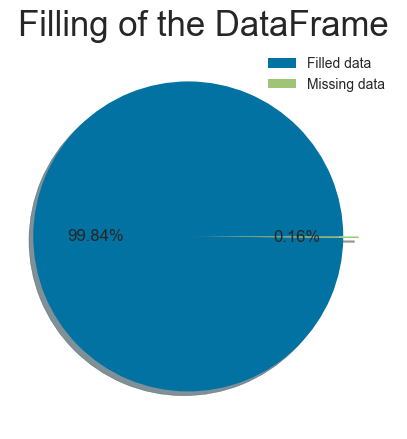

In [23]:
filling_rate(df_clients)

#### Au vu de ce que represente le % des valeurs manquantes nous pouvons les supprimer

In [24]:
df_clients.describe(include='all')

,customer_unique_id,nb_orders,first_order_date,last_order_date,total_spent,avg_review_score,nb_payment_types,recency,avg_days_between_orders
count,96096,96096.000000,96096,96096,95420.000000,95380.000000,96096.000000,96096.000000,96096.000000
unique,96096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0000366f3b9a7992bf8c76cfdf3221e2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.034809,2017-12-30 19:19:10.429206016,2018-01-02 12:40:19.655864832,174.426025,4.084696,1.026661,287.735691,0.307124
min,NaN,1.000000,2016-09-04 21:15:19,2016-09-04 21:15:19,10.070000,1.000000,0.000000,0.000000,-1.000000
25%,NaN,1.000000,2017-09-11 19:52:06,2017-09-15 09:04:17.249999872,64.010000,4.000000,1.000000,163.000000,-1.000000
50%,NaN,1.000000,2018-01-18 13:33:08,2018-01-21 19:39:16,110.915000,5.000000,1.000000,268.000000,-1.000000
75%,NaN,1.000000,2018-05-04 10:38:45,2018-05-06 20:14:49.750000128,188.940000,5.000000,1.000000,397.000000,-1.000000
max,NaN,17.000000,2018-10-17 17:30:18,2018-10-17 17:30:18,13664.080000,5.000000,3.000000,772.000000,304.000000


In [25]:
df_clients.dropna(subset=['total_spent', 'avg_review_score'], inplace=True)

#### Nous allons selectionner nous features numeriques les plus pertinentes

In [26]:
features = [
    'recency',
    'nb_orders',
    'total_spent',
    'avg_review_score',
    'nb_payment_types',
    'avg_days_between_orders'
]

X = df_clients[features]

#### Nous travaillons avec des valeurs de differentes echelles, nous allons donc devoir passer par une etape de normalisation

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [28]:
X["nb_orders"].value_counts()

nb_orders
1     91741
2      2729
3       202
4        30
5         8
6         6
7         3
9         1
17        1
Name: count, dtype: int64

In [29]:
pd.DataFrame(X_scaled, columns=features)["nb_orders"].value_counts()

nb_orders
-0.163040     91741
 4.478769      2729
 9.120579       202
 13.762388       30
 18.404197        8
 23.046007        6
 27.687816        3
 36.971434        1
 74.105909        1
Name: count, dtype: int64

#### Notre scaler a bien conserve l'importance des valeurs importantes. Ce qui est primordiale pour ne pas perdre l'importance/impact de nos plus gros clients

## Maintenant nous allons devoir trouver le bon nombre de K cluster. Pour ca nous allons passer par la methode du coude

c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

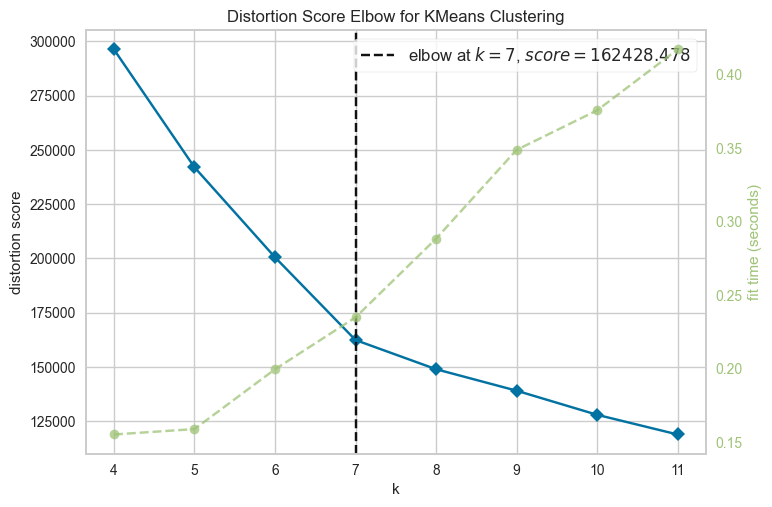

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X_scaled)
visualizer.poof()

c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


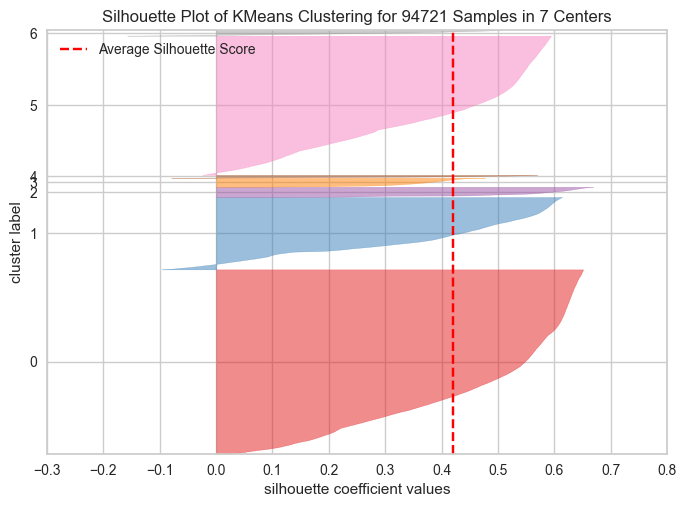

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 94721 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [42]:
model_2 = KMeans(7)
visualizer = SilhouetteVisualizer(model_2)

visualizer.fit(X_scaled)
visualizer.poof()

#### Ce score de silouhette est calcule en faisant la moyenne du coefficient de silhouette pour chaque échantillon, qui correspond à la différence entre la distance moyenne intra-grappe et la distance moyenne entre les grappes les plus proches pour chaque échantillon, normalisée par la valeur maximale.
#### On retrouve donc un score entre -1 et 1 où les scores proches de 1 indiquent une forte séparation et les scores proches de -1 indiquent que les échantillons peuvent avoir été assignés au mauvais groupe.

#### Nous obtenons donc un K = 7

In [34]:
# Nous pouvons recuperer le nombre de clusters optimal de cette facon 
opt_k = visualizer.elbow_value_
print("Le nombre optimal de clusters est : ", opt_k)

Le nombre optimal de clusters est :  7


In [35]:
optimal_k = opt_k
final_model = KMeans(n_clusters=optimal_k, random_state=42)
df_clients['cluster'] = final_model.fit_predict(X_scaled)

c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [38]:
df_clients['cluster'].value_counts()

cluster
0    41254
5    31125
3    16180
2     2283
1     2004
6     1209
4      666
Name: count, dtype: int64

#### Nous allons mener quelques analyses sur ces clusters

In [40]:
df_clusters = df_clients.groupby('cluster')[features].mean()
df_clusters

,recency,nb_orders,total_spent,avg_review_score,nb_payment_types,avg_days_between_orders
cluster,,,,,,
0,170.350536,1.000000,140.890480,4.677449,1.000000,-1.000000
1,295.977046,2.132735,318.940758,4.090499,1.020459,15.048014
2,301.773544,1.125274,313.809019,4.074018,2.006570,1.897249
3,287.487206,1.000000,161.416693,1.621508,0.999938,-1.000000
4,186.881381,2.106607,316.342117,4.270158,1.228228,128.566772
5,441.318972,1.000000,141.747753,4.633863,1.000000,-1.000000
6,294.399504,1.028122,1734.095988,3.940072,1.031431,-0.721323


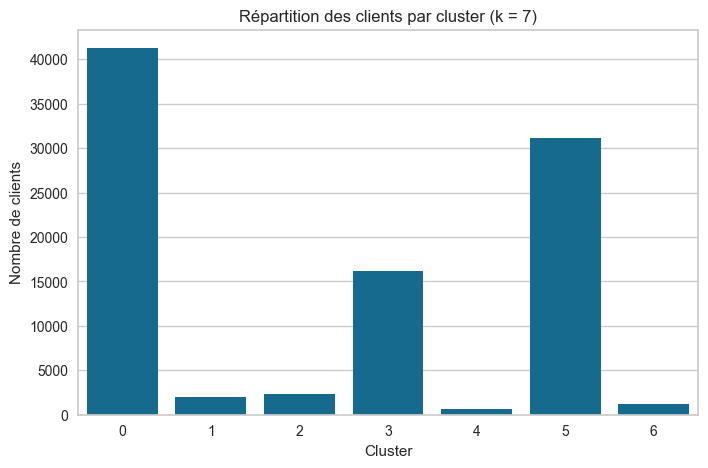

In [41]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_clients, x='cluster')
plt.xlabel("Cluster")
plt.ylabel("Nombre de clients")
plt.title("Répartition des clients par cluster (k = 7)")
plt.show()